In [27]:
import numpy as np
import tensorflow as tf
import pylab
%matplotlib inline

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
from random import shuffle # For shuffling start position list

Dim. of X-data: 100 x 2
Mean p: 
[ 0.58  0.52  0.48  0.56  0.48  0.58  0.48  0.5   0.52  0.58  0.44  0.43
  0.48  0.44  0.44  0.55  0.49  0.43  0.52  0.56  0.42  0.57  0.48  0.42
  0.54  0.46  0.47  0.55  0.41  0.45  0.59  0.41  0.44  0.47  0.49  0.54
  0.51  0.49  0.52  0.59  0.56  0.54  0.51  0.39  0.46  0.53  0.49  0.49
  0.43  0.44  0.55  0.41  0.51  0.52  0.54  0.52  0.42  0.56  0.53  0.54
  0.47  0.44  0.55  0.49  0.54  0.51  0.49  0.56  0.48  0.55  0.46  0.46
  0.5   0.41  0.5   0.48  0.37  0.4   0.56  0.49  0.63  0.45  0.57  0.45
  0.43  0.43  0.44  0.57  0.47  0.49  0.42  0.5   0.49  0.51  0.56  0.46
  0.47  0.46  0.63  0.53]
Dim. of Y-data: 100 x 100
Assumed f-mean:
[ 1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.5707963

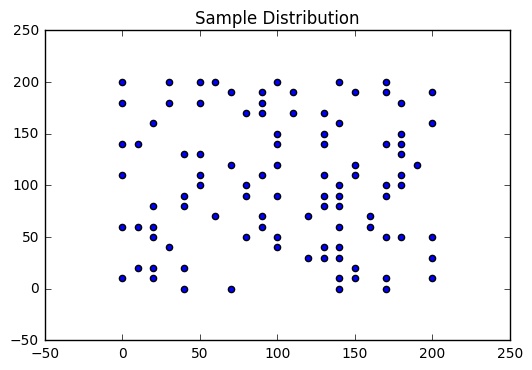

In [28]:
nr_inds=100  # Nr. of Individuals to Check

X_data = np.loadtxt('./coordinates7.csv', delimiter='$').astype('float64') # Load the complete X-Data
Y_data = np.loadtxt('./data_genotypes7.csv', delimiter='$').astype('float64') # Load the complete Y-Data
#print(len(X_data))
inds=range(len(X_data))
shuffle(inds)  # Random permutation of the indices. If not shuffle - comment out
inds=inds[:nr_inds]  # Only load first nr_inds


# Only load first nr_inds entries
X_data=X_data[inds,:]
Y_data=Y_data[inds,:]


#./data_genotypes5.csv has mean p=0.2

assert(len(X_data) == len(Y_data))

N = X_data.shape[0]
k = X_data.shape[1]
print("Dim. of X-data: %i x %i" % (N,k))
M1 = Y_data.shape[0]
nr_loci = Y_data.shape[1]


p_mean = np.mean(Y_data, axis=0) # Empirical average for every loci
#p_mean=np.mean(Y_data)
print("Mean p: ")
print(p_mean)

# Change this for coordinates5.csv  (If mean is known)
#f_mean = np.loadtxt('./mean_f6.csv', delimiter='$').astype('float64')[inds]   # Empirical f_mean
#f_mean = np.log(p_mean) - np.log(1 - p_mean) # Does a Logit Transform
#f_mean=np.log(0.2)-np.log(1.0-0.2)   # If known

#print(len(f_mean))
#print(len(f_mean))
Y_data[Y_data < 0.5] = -1.0  # For the logit Link function
print("Dim. of Y-data: %i x %i" % (M1, nr_loci))

#mean_paramss = np.array([f_mean for _ in range(nr_loci)]) # Initial Parameter for the mean-parameters
#mean_paramss = np.array([0.0 for _ in range(nr_loci)])  # Set everything to 0
mean_paramss = np.array([np.pi/2.0 for _ in range(nr_loci)])  # Set everything to 0.5. For ArcSin Model
#mean_paramss = np.array(f_mean)
print("Assumed f-mean:")
print(mean_paramss)

# Plot the data
pylab.figure()
pylab.title("Sample Distribution")
pylab.scatter(X_data[:,0], X_data[:,1])
pylab.show()

In [29]:
###### The Full Kernel:
def full_kernel_function(coords):
    '''Return barrier Kernel - describing reduced correlation across barrier
    and increased correlation next to barrier. Coords is nx2 Numpy array'''
    x = coords[:, 0]  # Extracts x-coords
    coords_refl = np.copy(coords)
    coords_refl[:, 0] = -coords_refl[:, 0]  # Reflects the samples
    
    g = np.sign(x)  # Calculates Signum of x
    same_side = (g[:,None] * g + 1) / 2  # Whether the x-Values are on the same side
    print("Same Side Vector: ")
    print(same_side)
    
    r = np.linalg.norm(coords[:, None] - coords, axis=2)  # Calculates pairwise Distance
    r_refl = np.linalg.norm(coords_refl[:, None] - coords, axis=2)  # Calculates the reflected Distance 
    
    l = float(input("What length scale? \n"))
    a = float(input("What absolute correlation?\n"))
    c = float(input("What is the refl. factor of the barrier?\n"))
    
    # Calculate the normal Kernel:
    cov_mat = a * np.exp((-r ** 2) / (2. * l ** 2))  # Calculate the co-variance matrix. Added diagonal term
    print("R")
    print(r)
    print("R_refl: ")
    print(r_refl)
    cov_mat_refl = a * np.exp((-r_refl ** 2) / (2. * l ** 2))  # Calculate the covariance matrix for reflected coordinates.
    
    cov_tot = same_side * (cov_mat + c * cov_mat_refl) + (1 - same_side) * (1 - c) * cov_mat + 0.000001 * np.identity(len(coords))
    print("Covariance Matrix: ")
    print(cov_tot)
    print("Eigenvalues: ")
    print(np.linalg.eig(cov_mat)[0])
    return cov_tot

In [30]:
# From Alex: To calculate the log determinant

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    
    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))
    
    tf.RegisterGradient(rnd_name)(grad)
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def py_logdet(x, name=None):
    
    with ops.op_scope([x], name, "Logdet") as name:
        logdet = py_func(lambda x: np.linalg.slogdet(x)[1],
                         [x],
                         [tf.float64],
                         name=name,
                         grad=_LogdetGrad)  # <-- here's the call to the gradient
    return logdet[0]

def _LogdetGrad(op, grad):
    x = op.inputs[0]
    return tf.matrix_inverse(x) * grad[:, None, None]

In [220]:
# For logit Link function

with tf.device('/cpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value = X_data, trainable=False)
    Y = tf.Variable(dtype=tf.float64, initial_value = Y_data, trainable=False)
    F = tf.Variable(dtype=tf.float64, initial_value = np.random.normal(0.5, 0.1, (N, nr_loci)).astype('float64'),
                    trainable=True)

    hyper_params = tf.placeholder(shape=[2+nr_loci], dtype=tf.float64)      # HyperParameters for the Kernel
    # First two are for the kernel; nr_loci are for the means of the GRFs!
    #mean_params = tf.placeholder(shape=[nr_loci], dtype=tf.float64)  # HyperParameters for the mean Values
    
    l = tf.abs(hyper_params[1])     # The old kernel parameter
    a = tf.abs(hyper_params[0])     # The old kernel parameter
    mean_param = hyper_params[2:]   # The mean parameters
    
    eye = tf.eye(N)

    K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l **2), reduction_indices=[2])) + \
        0.00001 * tf.eye(N, dtype=tf.float64) # Calculate Matrix of Covariances
    
    #K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l), reduction_indices=[2])) + \
       # 0.0001 * eye                

    f_tot = F + mean_param[None, :]    # Adds mean term; None is at position of an individual
    #f_tot= F + f_mean[None,:]          # Adds empirical mean term
    #f_tot = F + f_mean                 # For the case that there is a single Value
    p = tf.nn.sigmoid(f_tot)            # Calculate probabilities(assuming sigmoid link function)
    Kinv_F = tf.matrix_solve(K, F)      # Calculate K^(-1)*F
    
    data_fit = -tf.reduce_sum(tf.log(1 + tf.exp(-Y * f_tot)), reduction_indices=[0]) # Calculate Data Fit: Check  
    prior_fit = -0.5 * tf.reduce_sum(F * Kinv_F, reduction_indices=[0])          # Calculate 1st term of prior probability: Check
    
    logL = tf.reduce_sum(data_fit + prior_fit) # Modulo terms not depending on f: Check
    
    g =  (0.5 * (Y + 1) - p) - Kinv_F # Calculate Matrix for Gradients Check
    
    W = p * (1 - p)        # Calculate first part of Hessian. It is diagonal (but here diagonal in every column)
    lhs = -K[:, :, None] * W[None, :, :] - tf.eye(N, dtype=tf.float64)[:, :, None] # Check (HEADACHE)
    #lhs = -K[:, :, None] * W[None, :, :] - eye[:, :, None] 
    rhs = tf.matmul(K, g)
    
    update = tf.matrix_solve(tf.transpose(lhs, [2, 0, 1]), tf.transpose(rhs, [1, 0])[:, :, None])[:, :, 0]
    update = tf.transpose(update)
    
    opt_op = F.assign(F - update)
    
    #####
    
    B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + tf.eye(N, dtype=tf.float64)[:, :, None]  # Check
    #B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + eye[:, :, None] 
    
    logdet = tf.reduce_sum(py_logdet(tf.transpose(B, [2, 0, 1])))  # Factor of 2??
    
    margL = logL - 0.5 * logdet
    
    ##### Gradients and Hessian #######################3
    
    #grad = tf.gradients(margL, hyper_params)
    #hessian = tf.hessians(margL, hyper_params)  # Comment out to avoid computational overhead.

In [31]:
# For sin^2(x/2) Link function
def link_f(f):   # Define Link function
    '''Sinus Squared Link function'''
    pi=0.99*np.pi*tf.ones((N,nr_loci), dtype=tf.float64)  # Matrix - for values bigger than Pi. 
    #Allow for values slightly smaller than Pi to infinte likelihood
    z=0.01*tf.ones((N,nr_loci), dtype=tf.float64)       
    # Matrix - for values smaller than 0. Allow for small values slightly bigger than 1
    f=tf.where(f>np.pi, pi, f)       # Make values bigger than pi almost pi
    f=tf.where(f<0, z, f)            # Make values smaller than 0 almost 0
    
    y = tf.sin(0.5*f) ** 2        # Do the actual calculation
    return y

with tf.device('/cpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value = X_data, trainable=False)
    Y = tf.Variable(dtype=tf.float64, initial_value = Y_data, trainable=False)
    F = tf.Variable(dtype=tf.float64, initial_value = np.random.normal(0.0, 0.1, (N, nr_loci)).astype('float64'),
                    trainable=True)

    hyper_params = tf.placeholder(shape=[2+nr_loci], dtype=tf.float64)      # HyperParameters for the Kernel
    # First two are for the kernel; nr_loci are for the means of the GRFs!
    #mean_params = tf.placeholder(shape=[nr_loci], dtype=tf.float64)  # HyperParameters for the mean Values
    
    l = tf.abs(hyper_params[1])     # The Parameter for the length scale
    a = tf.abs(hyper_params[0])     # The Parameter for the absolute correlation
    mean_param = hyper_params[2:]   # The mean parameters
    
    eye = tf.eye(N)

    K = a * tf.exp(-tf.reduce_sum(((X[:, None] - X[None, :]) ** 2) / (2 * l **2), reduction_indices=[2])) + \
        0.00001 * tf.eye(N, dtype=tf.float64) # Calculate Matrix of Covariances: Here RBF-Kernel
    
    f_tot = F + mean_param[None, :]    # Adds mean term; None is at position of an individual
    #f_tot= F + f_mean[None,:]          # Adds empirical mean term
    #f_tot = F + f_mean                 # For the case that there is a single Value
    p = link_f(f_tot)    # Calculate novel p, assuming sin^2 Link Function
    Kinv_F = tf.matrix_solve(K, F)      # Calculate K^(-1)*F
    
    g0 = tf.greater(Y, 0.5)        # Values where Y is greater than 0; i.e. data is 1.
    g0 = tf.cast(g0, tf.float64)   # Transform so that can be multiplied

    y_f= g0*p + (1-g0)*(1-p)  # Probability of observing y given probabilities p
    
    data_fit = tf.reduce_sum(tf.log(y_f), reduction_indices=[0])   # Calculate Data Fit: Check  
    prior_fit = -0.5 * tf.reduce_sum(F * Kinv_F, reduction_indices=[0])          # Calculate 1st term of prior probability: Check
    
    logL = tf.reduce_sum(data_fit + prior_fit) # Modulo terms not depending on f: Check
    
    d1 = 1.0/tf.tan(0.5*f_tot)   # Gradient coming from f_tot (for y=1)
    d0 = -tf.tan(0.5*f_tot)      # Gradient comfing from t_tot (for y=0)
    
    grad1 = g0*d1 + (1-g0)*d0  # First part of the gradient
    
    g =  grad1 - Kinv_F       # Calculate Matrix for Gradients Check
    
    h1 = -0.5 / ((tf.sin(0.5 * f_tot))**2) # Minus second derivative of data. (for y=1)
    h0 = -1.0 / (1 + tf.cos(f_tot))        # Second derivative of data (for y=0)
    W = - g0*h1 - (1-g0)*h0       # Calculate first part of Hessian. It is diagonal (but here diagonal in every column)
    
    lhs = -K[:, :, None] * W[None, :, :] - tf.eye(N, dtype=tf.float64)[:, :, None] # Check (HEADACHE)
    #lhs = -K[:, :, None] * W[None, :, :] - eye[:, :, None] 
    rhs = tf.matmul(K, g)
    
    update = tf.matrix_solve(tf.transpose(lhs, [2, 0, 1]), tf.transpose(rhs, [1, 0])[:, :, None])[:, :, 0]
    update = tf.transpose(update)
    
    opt_op = F.assign(F - update)
    
    #####
    
    B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + tf.eye(N, dtype=tf.float64)[:, :, None]  # Check
    #B = (W[:, None, :] ** 0.5) * K[:, :, None] * (W[None, :, :] ** 0.5) + eye[:, :, None] 
    
    logdet = tf.reduce_sum(py_logdet(tf.transpose(B, [2, 0, 1])))  # Factor of 2??
    
    margL = logL - 0.5 * logdet
    
    ##### Gradients and Hessian #######################3
    
    grad = tf.gradients(margL, hyper_params)
    hessian = tf.hessians(margL, hyper_params)  # Comment out to avoid computational overhead.

In [33]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.01

In [34]:
### Optimization Run
hyper_paramss = np.array([0.012,25]) # The initial values for a & L
hyper_paramss = np.append(hyper_paramss, mean_paramss)

#kk =  np.array([0.012, 20] + f)



with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(100):
        print("Doing Run: %i" %i)
        _, r,  g, h = sess.run([opt_op, margL, grad, hessian], {hyper_params: hyper_paramss})  
        print(r)
        
        if i < 3:  # First three times just run to optimize f_i
            continue
        
        u = np.matmul(np.linalg.inv(h[0]), g[0]) 
        hyper_paramss -= u
        print(hyper_paramss, u)
    
    # Code for calculating empirical Fisher-Information Matrix:
fisher_info = np.matrix(h[0])
stds = np.sqrt(np.diag(-fisher_info.I)) # Calculates the Standard Deviations (Sqrt of Variance)
print("Standard Deviations: ")
print(stds)

Doing Run: 0
-558312.307774
Doing Run: 1
-6928.65847433
Doing Run: 2
-6928.64742682
Doing Run: 3
-6928.64742679


NameError: name 'kk' is not defined

In [8]:
kk

array([  7.43975768e-02,   1.21932542e+01,  -2.90546867e-01,
         2.93960411e-01,  -1.23718358e-01,   1.67181388e-01,
        -2.45848322e-01,  -3.28000963e-01,  -2.44680984e-01,
         1.54908960e-01,   4.92361715e-02,   6.26150965e-01,
         3.69560651e-01,   2.03616255e-01,  -1.20633605e-01,
         2.93626424e-01,  -5.40031470e-01,   3.76028731e-01,
         3.71718840e-01,  -5.40893312e-01,  -3.72765628e-01,
         1.17959531e-01,   3.24129795e-01,   8.02742558e-02,
        -1.58833486e-01,  -2.92273304e-01,  -3.63714249e-03,
        -7.54080030e-02,   8.89832507e-02,  -1.23963682e-01,
        -2.03942141e-01,  -2.49734561e-01,  -3.92745444e-02,
        -2.48554611e-01,   2.47624736e-01,  -1.64935993e-01,
         2.81963825e-03,  -4.94734271e-01,  -2.38476357e-01,
         8.48715774e-02,  -3.50255430e-02,   2.39226818e-01,
         4.20188576e-01,   1.66484765e-01,  -2.06842326e-01,
         4.47823581e-02,  -4.20428059e-01,  -1.95101049e-04,
        -4.57092325e-01,

In [21]:
#a_list = np.logspace(-1.5, -0.5, 10)   # Original Values

a_list=np.logspace(-3,-1.5,10)
l_list = np.logspace(1, 2, 10)

#a_list = np.logspace(-3, -0.5, 10)
#l_list = np.logspace(0, 2, 10)


print(a_list)
print(l_list)

[ 0.001       0.0014678   0.00215443  0.00316228  0.00464159  0.00681292
  0.01        0.01467799  0.02154435  0.03162278]
[  10.           12.91549665   16.68100537   21.5443469    27.82559402
   35.93813664   46.41588834   59.94842503   77.42636827  100.        ]


In [22]:
res = []
j=0
print("Mean Parmaters: ")
print(mean_paramss)
with tf.Session(config=config) as sess:
    for aa in a_list:
        for ll in l_list:
            print("Doing run: %i" % j)
            j+=1
    
            sess.run(tf.global_variables_initializer())   # Changed to global_variables_initializer

            prev = None
            for i in range(20):
                hyper_paramss = np.array([aa,ll])
                hyper_paramss = np.append(hyper_paramss, mean_paramss)
                
                r = sess.run([opt_op, update, logL, margL], {hyper_params: hyper_paramss})
                if prev and np.abs(prev - r[-1]) < 0.01:
                    break
                prev = r[-1]
            print("Tested a: %4f" % aa)
            print("Tested l: %4f" % ll)
            print("Marginal Likelihood: %4f" % r[-1])
            res.append(r[-1])

Mean Parmaters: 
[ 1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633  1.57079633
  1.57079633  1.57079633  1.570796

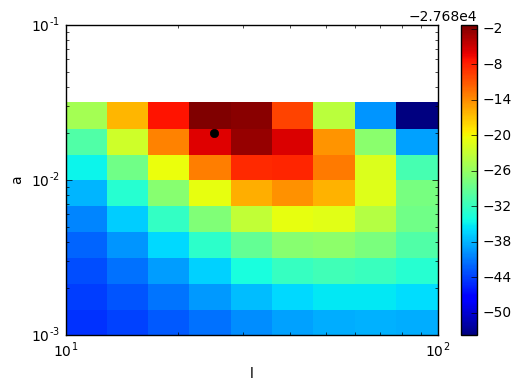

In [24]:
surface = np.array(res).reshape((10, 10))
pylab.pcolormesh(l_list, a_list, surface)
pylab.xscale('log')
pylab.yscale('log')
pylab.xlabel('l')
pylab.ylabel('a')
pylab.colorbar()
#pylab.plot(25, 0.1, 'ko', linewidth=5)
pylab.plot(25,0.02,'ko',linewidth=5)

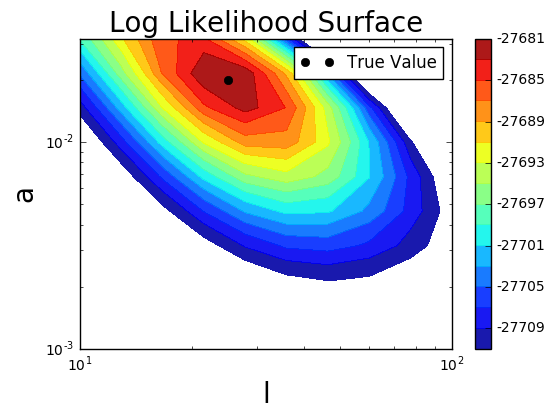

In [25]:
pylab.figure()
levels = np.arange(max(res) - 30, max(res) + 1, 2)  # Every two likelihood units
ax=pylab.contourf(l_list, a_list, surface, alpha=0.9, levels=levels)

# plt.clabel(ax, inline=1, fontsize=10)
pylab.colorbar(ax, format="%i")
pylab.title("Log Likelihood Surface", fontsize=20)
pylab.xlabel("l", fontsize=20)
pylab.ylabel("a", fontsize=20)
pylab.xscale('log')
pylab.yscale('log')
pylab.plot(25, 0.02, 'ko', linewidth=5, label="True Value")
pylab.legend()
pylab.show()

In [212]:
aa, ll = 0.1, 25
kk = np.array([0.1, 25])
kk = np.append(kk, mean_paramss)
print("Hyper Parameters: ")
print(kk)

Hyper Parameters: 
[  0.1  25.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0. ]


In [256]:
# Single Run; where optimization is computed.
with tf.Session(config=config) as sess:
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())   # Update by Harald
    
    for i in range(5):
        sess.run(opt_op, {hyper_params: kk})
    r = sess.run([f_tot, F, logdet, margL, g0, W, B], {hyper_params: kk})
print("f_tot:")
print(r[0])
print("F:")
print(r[1])
print("logdet:")
print(r[2])
print("Marg.L")
print(r[3])
print("Likelihood: ")
print(r[4])
print("W: ")
print(r[5])
print("B: ")
print(r[6])
print("g0")
print(r[-5])
print("H0: ")
print(r[-4])
print("H1: ")
print(r[-3])
print("do: ")
print(r[-2])
print("d1: ")
print(r[-1])
#print(np.max(r[0])) # Calculates Maximum and Minimum of estimated F-Values
#print(np.min(r[0]))

f_tot:
[[-0.13011979  0.59826373  0.30743505 ...,  0.07565983  0.28164226
  -0.79447107]
 [-0.03083025  0.32985779  0.09493162 ...,  0.18809099  0.11559359
  -0.59291367]
 [ 0.1326414   0.04251985 -0.02914993 ...,  0.11820584 -0.02277171
  -0.28677294]
 ..., 
 [-0.20312324  0.05169753  0.31897605 ...,  0.29348691 -0.40073029
   0.11907882]
 [-0.15913084 -0.08286587  0.15559971 ...,  0.61000476 -0.36869958
  -0.07372863]
 [ 0.04833875 -0.42046249 -0.08574402 ...,  0.68229086 -0.15511149
  -0.16583276]]
F:
[[-0.13011979  0.59826373  0.30743505 ...,  0.07565983  0.28164226
  -0.79447107]
 [-0.03083025  0.32985779  0.09493162 ...,  0.18809099  0.11559359
  -0.59291367]
 [ 0.1326414   0.04251985 -0.02914993 ...,  0.11820584 -0.02277171
  -0.28677294]
 ..., 
 [-0.20312324  0.05169753  0.31897605 ...,  0.29348691 -0.40073029
   0.11907882]
 [-0.15913084 -0.08286587  0.15559971 ...,  0.61000476 -0.36869958
  -0.07372863]
 [ 0.04833875 -0.42046249 -0.08574402 ...,  0.68229086 -0.15511149
  -0.1

In [136]:
x, y, z = X_data[:nr_inds, 0], X_data[:nr_inds, 1], r[0][:,1]
#x=np.linspace(0, 1, 20)
#print(len(x))
print(len(x))
print(len(y))
print(len(z))

100
100
100


In [100]:
pylab.pcolormesh(x, y, z.reshape(21,21))
pylab.colorbar()

ValueError: total size of new array must be unchanged

In [ ]:
x.shape

In [ ]:
y.shape

In [ ]:
z.shape

In [ ]:
961 ** 0.5

In [43]:
with tf.device('/cpu:0'):
    X = tf.Variable(dtype=tf.float64, initial_value = 0, trainable=False)

In [76]:
with tf.device('/cpu:0'):   # For debugging
    d=tf.diag(tf.ones(5))
    c=2*tf.ones((5,5))
    b=tf.zeros((5,5))
    d=tf.where(d>0.5,c,d)
    res=tf.where(d<0.5,-c,d)

In [77]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    r=sess.run([res])

In [78]:
r

[array([[ 2., -2., -2., -2., -2.],
        [-2.,  2., -2., -2., -2.],
        [-2., -2.,  2., -2., -2.],
        [-2., -2., -2.,  2., -2.],
        [-2., -2., -2., -2.,  2.]], dtype=float32)]

In [ ]:
tf.__version__

In [ ]:
logdet

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    r = sess.run(logdet, {a: 1.0, l: 1.0})

In [ ]:
r